# Analyses of session part clusters


In [3]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
import pandas as pd
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go 

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//4_analyses/4_Clustering/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial/4_analyses/4_Clustering/'
os.chdir(functions_path)
from clustering_functions import revert_to_original, get_ballistic, get_no_resp

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Get data

In [4]:
# Full file path for dumping
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/')

# DATA used for COSYNE: states_trial_type_14oct2024

In [7]:
# Load old trial clsuters to get ballistic trials
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
trials_filename = str(results_path + 'cluster_per_trial01-09-2025')
old_trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
# mouse_filename = str(results_path + 'cluster_per_mouse01-09-2025')
# old_mouse_clusters = pd.read_parquet(mouse_filename, engine='pyarrow')

In [5]:
# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
# results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'

# trials_filename = str(results_path + 'cluster_per_trial_part_info03-12-2025')
# trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
# parts_filename = str(results_path + 'cluster_per_session_part03-12-2025')
# parts_clusters = pd.read_parquet(parts_filename, engine='pyarrow')

trials_filename = str(results_path + 'cluster_per_trial_part_info03-19-2025')
trial_clusters = pd.read_parquet(trials_filename, engine='pyarrow')
parts_filename = str(results_path + 'cluster_per_session_part03-19-2025')
parts_clusters = pd.read_parquet(parts_filename, engine='pyarrow')

In [9]:
# old_trial_clusters = old_trial_clusters.rename(columns={"sample": "old_sample"})
# trial_clusters = trial_clusters.merge(old_trial_clusters[['old_sample', 'mouse_name', 
#                                                           'perseverence', 'wsls', 'ballistic']].drop_duplicates(), on=['old_sample', 'mouse_name'])

## Plot parts cluster features

In [8]:
mean_cluster_parts = pd.DataFrame(parts_clusters.groupby(['part_cluster', 'cluster'])['relative_frequency'].mean()).reset_index()


In [9]:

plt_vars = ['0', '1', '2', '3', '4', '5', '6'] 

unique_clusters = [0, 1, 2, 3, 4, 5, 6]
new_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6}

mapping = {
    cluster: label
    for cluster, label in zip(unique_clusters, plt_vars)
}
mapping
replace_func = np.vectorize(mapping.get)

replace_func = np.vectorize(new_dict.get)
mean_cluster_parts['new_clusters'] = mean_cluster_parts['cluster'].copy()
mean_cluster_parts['new_clusters'] = replace_func(mean_cluster_parts['cluster'])


In [10]:
mean_cluster_parts['label'] = mean_cluster_parts['cluster'].copy()
mean_cluster_parts['label'] = replace_func(mean_cluster_parts['label'])

mean_cluster_parts.sort_values(by='label')

# Custom order (array) for the 'name' column
custom_order = ['Right ballistic','Accurate, long pre-quiescence','Long reaction', 'Left ballistic',
            'Left non-ballistic','Right non-ballistic'] 
custom_order = ['0', '1', '2', '3', '4', '5', '6']

# Convert the 'name' column to a categorical type with the specified order
mean_cluster_parts['label'] = pd.Categorical(mean_cluster_parts['label'], categories=custom_order, ordered=True)


In [11]:
# Choose a Seaborn palette and convert it to HEX format
palette = sns.light_palette("seagreen", 3, as_cmap=False)
colors = [f'rgba({int(r*255)},{int(g*255)},{int(b*255)},.6)' for r, g, b in palette]  # Adjust transparency if needed

# Create the figure
fig = go.Figure()

# Add traces with custom colors and dark grey contours
for i in range(3):  # Assuming 3 clusters
    fig.add_trace(go.Scatterpolar(
        r=pd.Series(mean_cluster_parts.sort_values(by='new_clusters')
                    .loc[mean_cluster_parts['part_cluster'] == i, 'relative_frequency'].values),
        theta=plt_vars,
        fill='toself',
        name=f'Part cluster {i}',
        line=dict(color='darkgrey', width=2),  # Dark grey contour
        fillcolor=colors[i]  # Assign Seaborn fill colors
    ))

# Update layout
fig.update_layout(
    polar=dict(
        angularaxis=dict(tickfont=dict(size=16)),  # Set font size for theta labels
        radialaxis=dict(visible=True, tickfont=dict(size=16))
    ),
    showlegend=True
)

fig.show()

In [15]:

plt.rcParams.update({'font.size': 16})

# plot star plot for comparison 
fig = go.Figure() 
fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_parts.sort_values(by='new_clusters').loc[mean_cluster_parts['part_cluster']==0, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Part cluster 0' 
)) 
fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_parts.sort_values(by='new_clusters').loc[mean_cluster_parts['part_cluster']==1, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Part cluster 1'
)) 

fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_parts.sort_values(by='new_clusters').loc[mean_cluster_parts['part_cluster']==2, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Part cluster 2'
)) 
 
  
fig.update_layout( 
  polar=dict(
        angularaxis=dict(
            tickfont=dict(size=16)  # Set the font size of the theta labels
        ),
    radialaxis=dict( 
      visible=True,
      tickfont=dict(size=16)
          )), 
  
  showlegend=True
)  #     template = 'plotly_dark', 

plt.savefig(file_path+'star_plots_mice.svg', format="svg")
# fig.write_image(file_path + 'star_plots_mice.svg')

fig.show() 

<Figure size 640x480 with 0 Axes>

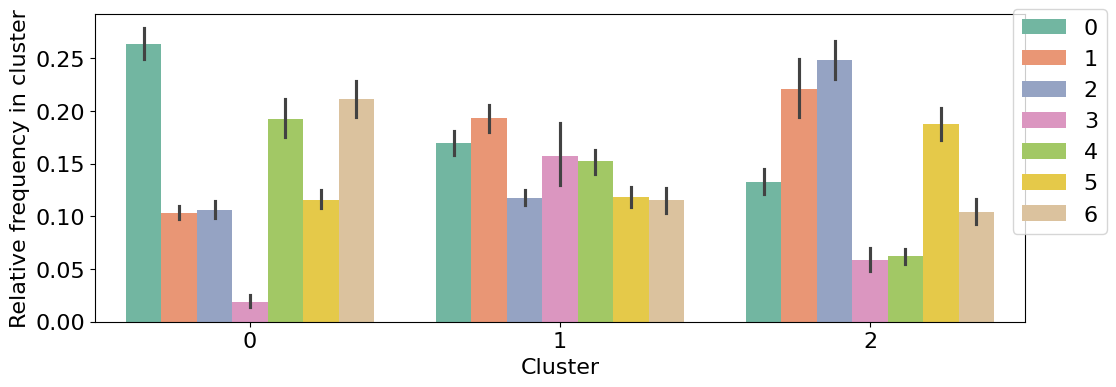

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x='part_cluster', y='relative_frequency', hue='cluster', data=parts_clusters, palette='Set2')
plt.ylabel('Relative frequency in cluster')
plt.xlabel('Cluster')
plt.legend(bbox_to_anchor=(1.1, 1.05))

## Merge trial info and mouse clusters

In [12]:
part_trials_df = parts_clusters.merge(trial_clusters[['mouse_name', 'sample', 'reaction', 'response', 
                                                      'elongation', 'feedback', 'ballistic', 'wsls', 'perseverence',
                                                      'choice', 'side', 'contrast', 'block']], on=['mouse_name', 'sample'])
# new_df = pd.DataFrame(new_df.groupby(['mouse_name', 'mouse_cluster'])['reaction', 'response', 'elongation', 'correct', 'ballistic'].mean()).reset_index()

KeyError: "['wsls', 'perseverence'] not in index"

In [13]:
part_trials_df = parts_clusters.merge(trial_clusters[['mouse_name', 'sample', 'reaction', 'response', 
                                                      'elongation', 'feedback', 'ballistic', 
                                                      'choice', 'side', 'contrast', 'block']], on=['mouse_name', 'sample'])
# new_df = pd.DataFrame(new_df.groupby(['mouse_name', 'mouse_cluster'])['reaction', 'response', 'elongation', 'correct', 'ballistic'].mean()).reset_index()

/tmp/ipykernel_21514/1497057541.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_21514/1497057541.py:6: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



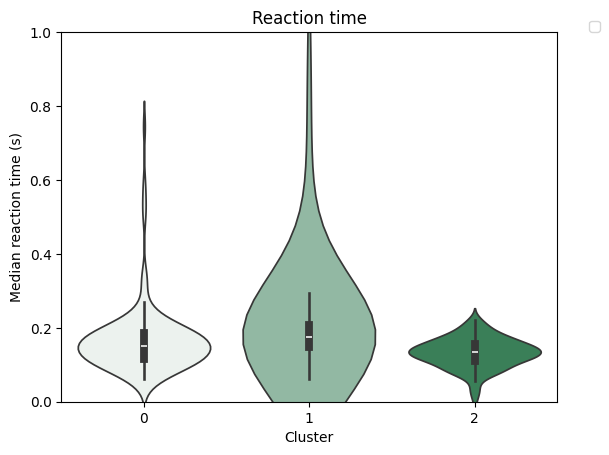

/tmp/ipykernel_21514/1497057541.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_21514/1497057541.py:16: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



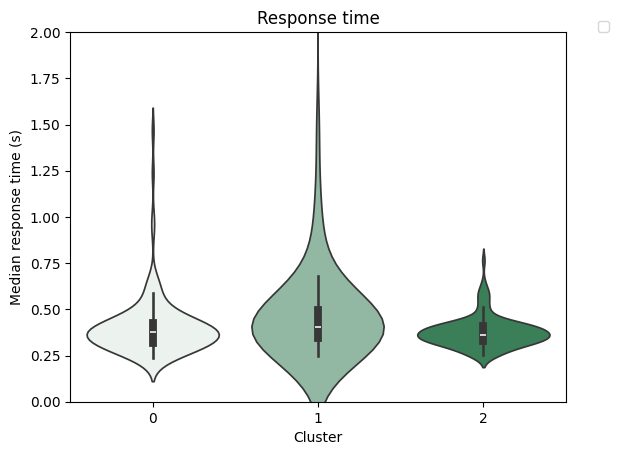

/tmp/ipykernel_21514/1497057541.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_21514/1497057541.py:26: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



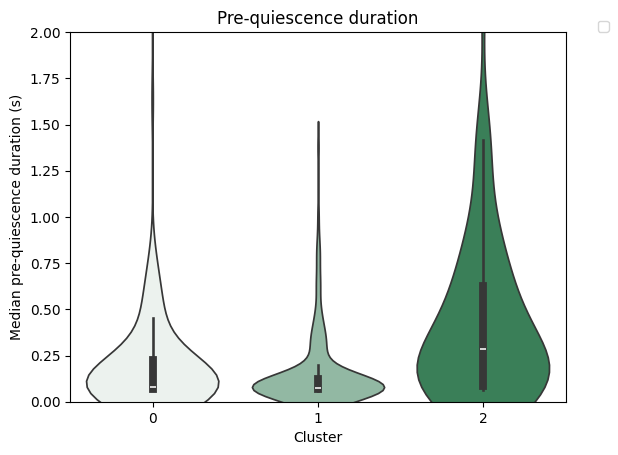

In [14]:
# part_trials_df = trial_clusters.merge(parts_clusters[['mouse_name', 'part_cluster']])

new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['reaction', 'response', 
                                                                                          'elongation']].median()).reset_index()
sns.violinplot(x='part_cluster', y='reaction', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylim([0, 1])
plt.title('Reaction time')
plt.ylabel('Median reaction time (s)')
plt.xlabel('Cluster')
plt.savefig(file_path+'reaction_mouse.svg', format="svg")

plt.show()

sns.violinplot(x='part_cluster', y='response', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Median response time (s)')
plt.ylim([0, 2])
plt.savefig(file_path+'response_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.violinplot(x='part_cluster', y='elongation', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Median pre-quiescence duration (s)')
plt.savefig(file_path+'elongation_mouse.svg', format="svg")
plt.ylim([0, 2])
plt.xlabel('Cluster')
plt.show()


/tmp/ipykernel_21514/321884299.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_21514/321884299.py:5: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



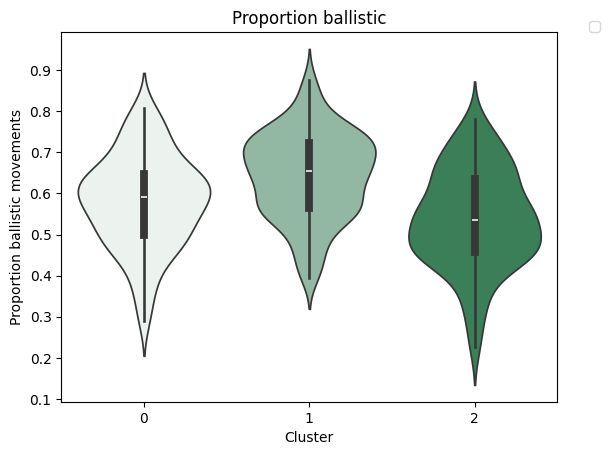

/tmp/ipykernel_21514/321884299.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_21514/321884299.py:14: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



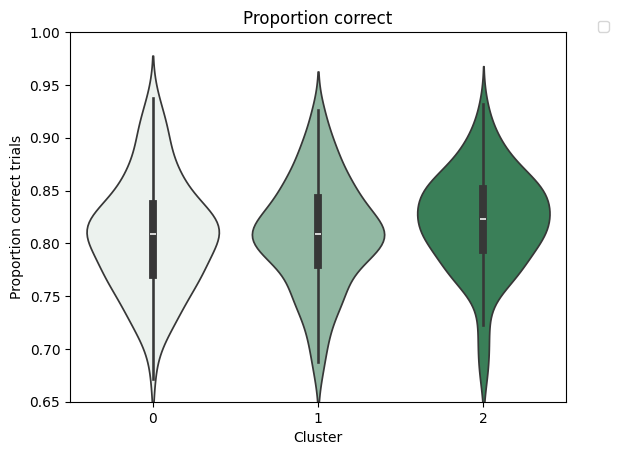

In [15]:

new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['feedback', 'ballistic',
                                                                                           'contrast', 'block']].mean()).reset_index()

sns.violinplot(x='part_cluster', y='ballistic', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic movements')
plt.savefig(file_path+'ballistic_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.violinplot(x='part_cluster', y='feedback', data=new_df, palette=sns.light_palette("seagreen", 3, as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylim([.65,1])
plt.title('Proportion correct')
plt.ylabel('Proportion correct trials')
plt.savefig(file_path+'correct_mouse.svg', format="svg")

plt.xlabel('Cluster')
# plt.ylim([.5, 1])
plt.show()

# sns.barplot(x='part_cluster', y='contrast', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Contrast')
# plt.ylabel('Contrast')
# # plt.savefig(file_path+'correct_mouse.svg', format="svg")

# plt.xlabel('Cluster')
# plt.ylim([.5, 1])
# plt.show()

# sns.violinplot(x='part_cluster', y='block', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Block probability')
# plt.ylabel('lock probability')
# # plt.savefig(file_path+'ballistic_mouse.svg', format="svg")
# plt.xlabel('Cluster')
# plt.show()



## Plot states per cluster

In [14]:
part_trials_df = parts_clusters.merge(trial_clusters, on=['mouse_name', 'sample', 'cluster'])

In [15]:
from matplotlib.colors import LinearSegmentedColormap

# Load color palette
colors = sns.cubehelix_palette(3,as_cmap=False)
colors = sns.color_palette("viridis", 3)

# Function to create a colormap from a base color (white to color)
def create_shaded_cmap(base_color, name='custom_cmap'):
    cdict = {
        'red':   [[0.0, 1.0, 1.0], [1.0, base_color[0], base_color[0]]],
        'green': [[0.0, 1.0, 1.0], [1.0, base_color[1], base_color[1]]],
        'blue':  [[0.0, 1.0, 1.0], [1.0, base_color[2], base_color[2]]]
    }
    return LinearSegmentedColormap(name, cdict)

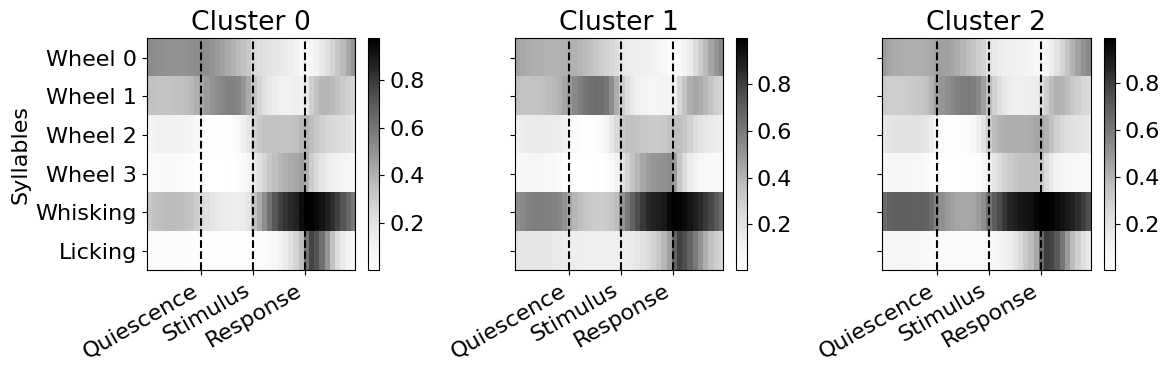

In [16]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)
# lick_states = replace_lick(use_sequences)
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, len(parts_clusters['part_cluster'].unique()), sharex=True, sharey=True, figsize=(12, 4))

for c, cluster in enumerate([0, 1, 2]):
    cluster_data = part_trials_df.loc[part_trials_df['part_cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    cmap_value_1 = create_shaded_cmap(colors[c], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    image = axs[c].imshow(all_stacked, cmap='Greys', aspect='auto')
    fig.colorbar(image, ax=axs[c], location='right', anchor=(0, 0.3))
    axs[c].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')

    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[c].set_title('Cluster ' +str(cluster))
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()

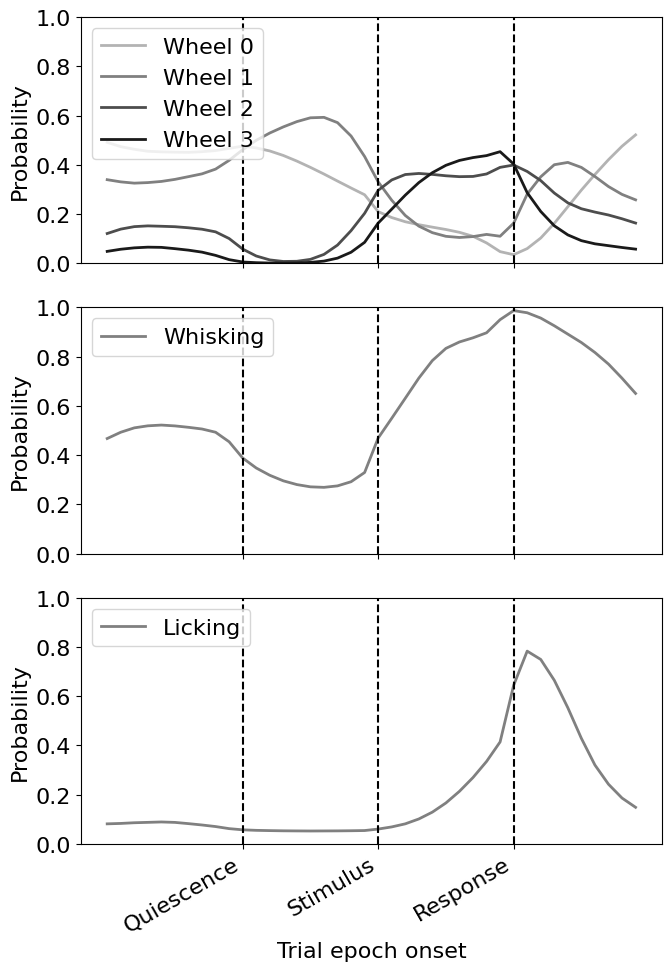

In [137]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(7, 10))

sequences_choice = np.vstack(part_trials_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

replace_whisker = np.vectorize(whisker_mapping.get)
whisker_states = replace_whisker(use_sequences)
replace_wheel = np.vectorize(wheel_mapping.get)
wheel_states = replace_wheel(use_sequences)    
replace_lick = np.vectorize(lick_mapping.get)
lick_states = replace_lick(use_sequences)

whisker_count = np.zeros((1, 40))
lick_count = np.zeros((1, 40))
wheel_count = np.zeros((4, 40))

for b, bin in enumerate(range(40)):
    whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
    lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
    wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
    wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
    wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
    wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])

all_stacked = np.vstack([wheel_count, whisker_count, lick_count])

num_lines = 4
colors = [str(1- 0.6 * (i / (num_lines - 1))-.3) for i in range(num_lines)]  # Light to dark gray
axs[0].set_prop_cycle(color=colors)
axs[0].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'], linewidth=2)
axs[1].plot(all_stacked[4:5, :].T, label='Whisking', color='grey', linewidth=2)
axs[2].plot(all_stacked[5:6, :].T, label='Licking', color='grey', linewidth=2)

axs[0].axvline(x=10, color='k', linestyle='--')
axs[0].axvline(x=20, color='k', linestyle='--')
axs[0].axvline(x=30, color='k', linestyle='--')
axs[1].axvline(x=10, color='k', linestyle='--')
axs[1].axvline(x=20, color='k', linestyle='--')
axs[1].axvline(x=30, color='k', linestyle='--')
axs[2].axvline(x=10, color='k', linestyle='--')
axs[2].axvline(x=20, color='k', linestyle='--')
axs[2].axvline(x=30, color='k', linestyle='--')
axs[2].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
# axs[0, c].set_title('Cluster ' +str(cluster))
axs[0].set_ylim([0,1])
axs[2].set_xlabel('Trial epoch onset')

axs[0].set_ylabel('Probability')
axs[1].set_ylabel('Probability')
axs[2].set_ylabel('Probability')

axs[0].legend(loc='upper left') # bbox_to_anchor=(1.05, 1.0),
axs[1].legend(loc='upper left')
axs[2].legend(loc='upper left')

plt.tight_layout()

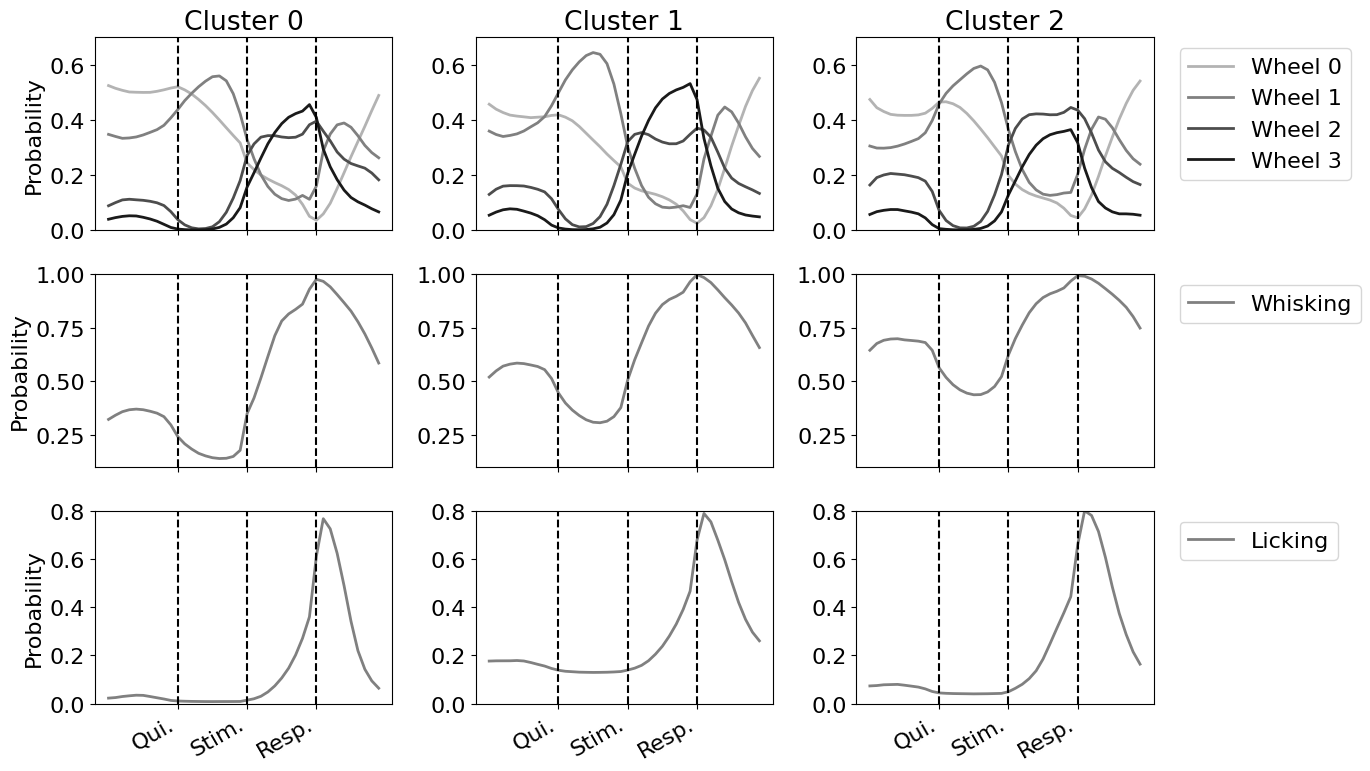

In [126]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

fig, axs = plt.subplots(3, len(parts_clusters['part_cluster'].unique()), sharex=True, sharey=False, figsize=(14, 8))

for c, cluster in enumerate([0, 1, 2]):
    cluster_data = part_trials_df.loc[part_trials_df['part_cluster']==cluster]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])

    num_lines = 4
    colors = [str(1- 0.6 * (i / (num_lines - 1))-.3) for i in range(num_lines)]  # Light to dark gray
    axs[0, c].set_prop_cycle(color=colors)
    axs[0, c].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'], linewidth=2)
    axs[1, c].plot(all_stacked[4:5, :].T, label='Whisking', color='grey', linewidth=2)
    axs[2, c].plot(all_stacked[5:6, :].T, label='Licking', color='grey', linewidth=2)

    axs[0, c].axvline(x=10, color='k', linestyle='--')
    axs[0, c].axvline(x=20, color='k', linestyle='--')
    axs[0, c].axvline(x=30, color='k', linestyle='--')
    axs[1, c].axvline(x=10, color='k', linestyle='--')
    axs[1, c].axvline(x=20, color='k', linestyle='--')
    axs[1, c].axvline(x=30, color='k', linestyle='--')
    axs[2, c].axvline(x=10, color='k', linestyle='--')
    axs[2, c].axvline(x=20, color='k', linestyle='--')
    axs[2, c].axvline(x=30, color='k', linestyle='--')
    axs[0, c].set_xticks(np.arange(10, 31, 10), ['Qui.', 'Stim.', 'Resp.'], rotation=30, ha='right')
    axs[1, c].set_xticks(np.arange(10, 31, 10), ['Qui.', 'Stim.', 'Resp.'], rotation=30, ha='right')
    axs[2, c].set_xticks(np.arange(10, 31, 10), ['Qui.', 'Stim.', 'Resp.'], rotation=30, ha='right')
    axs[0, c].set_title('Cluster ' +str(cluster))
    axs[0, c].set_ylim([0, 0.7])
    axs[1, c].set_ylim([0.1, 1])
    axs[2, c].set_ylim([0, 0.8])

axs[0, 0].set_ylabel('Probability')
axs[1, 0].set_ylabel('Probability')
axs[2, 0].set_ylabel('Probability')

axs[0, 2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[1, 2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[2, 2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()


## Cluster assignment entropy

In [8]:
# Load trial clsuters
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/4_analyses/'
filename = str(results_path + 'entropy03-13-2025')
entropy = pd.read_parquet(filename, engine='pyarrow')

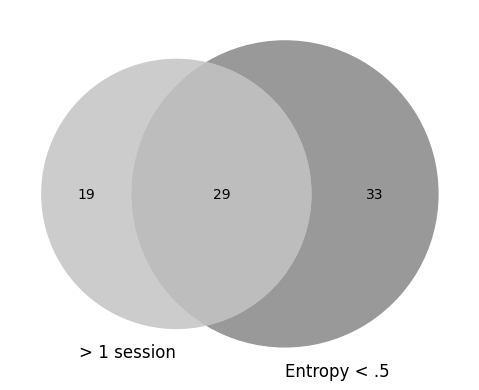

In [9]:
from matplotlib_venn import venn2

set1 = set(list(entropy.loc[(entropy['session_len']>1) & (entropy['variable']=='True'), 'mouse_name']))
set2 = set(list(entropy.loc[(entropy['value']<.3), 'mouse_name']))

venn2([set1, set2], ('> 1 session', 'Entropy < .5'), set_colors=("grey", "black"))

plt.show()

Text(29.222222222222214, 0.5, 'Mouse cluster entropy')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 7.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


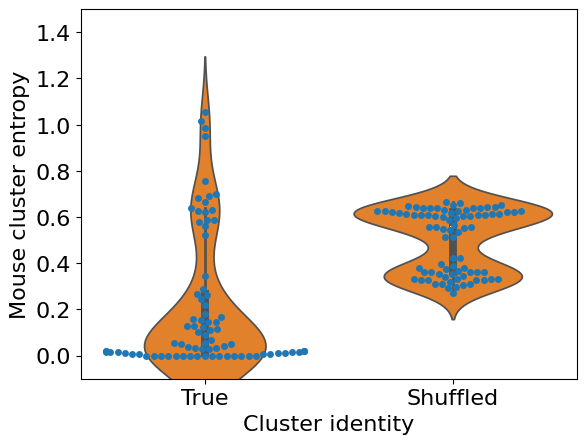

In [25]:
sns.swarmplot(x='variable', y='value', data=entropy)
sns.violinplot(x='variable', y='value', data=entropy)
plt.xlabel('Cluster identity')
plt.ylim([-.1, 1.5])
plt.ylabel('Mouse cluster entropy')

## Load learning data

In [50]:
# new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['feedback', 'ballistic',
#                                                                                            'contrast', 'block']].mean()).reset_index()
new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['feedback',
                                                                                           'contrast', 'block']].mean()).reset_index()
# new_df = pd.DataFrame(part_trials_df.groupby(['mouse_name', 'part_cluster', 'sample'])[['reaction', 'response', 
#                                                                                           'elongation']].median()).reset_index()

In [51]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')  
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()
df = new_df.merge(learning_times, on='mouse_name')

/tmp/ipykernel_13468/731117400.py:3: DtypeWarning:

Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.



In [65]:
quartiles = learning_times['training_time'].quantile(q=[0.25, 0.5, 0.75])
# quartiles = learning_times['training_time'].quantile(q=[0.33, 0.66])

In [66]:
learning_times['quartile'] = learning_times['training_time']*np.nan
learning_times.loc[learning_times['training_time']<=quartiles[0.25], 'quartile']= 1
learning_times.loc[(learning_times['training_time']>quartiles[0.25]) & (learning_times['training_time']<=quartiles[0.50]), 'quartile']= 2
learning_times.loc[(learning_times['training_time']>quartiles[0.50]) & (learning_times['training_time']<=quartiles[0.75]), 'quartile']= 3
learning_times.loc[learning_times['training_time']>quartiles[0.75], 'quartile']= 4

In [57]:
learning_times['quartile'] = learning_times['training_time']*np.nan
learning_times.loc[learning_times['training_time']<=quartiles[0.33], 'quartile']= 1
learning_times.loc[(learning_times['training_time']>quartiles[0.33]) & (learning_times['training_time']<=quartiles[0.66]), 'quartile']= 2
learning_times.loc[learning_times['training_time']>quartiles[0.66], 'quartile']= 3

In [49]:
df = new_df.merge(learning_times[['mouse_name', 'training_time', 'quartile']], on='mouse_name')

KeyError: "['quartile'] not in index"

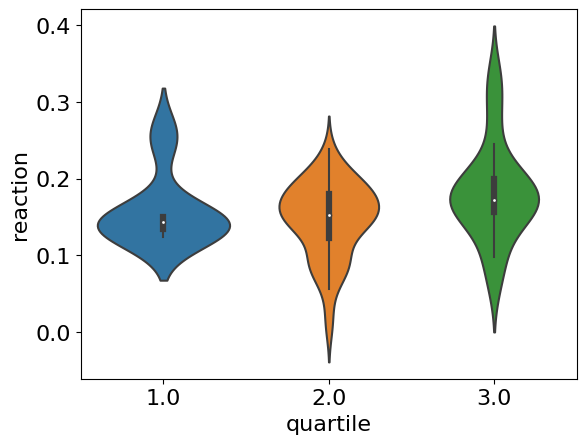

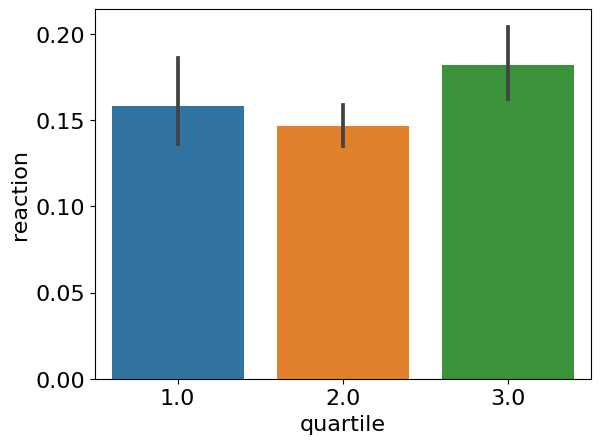

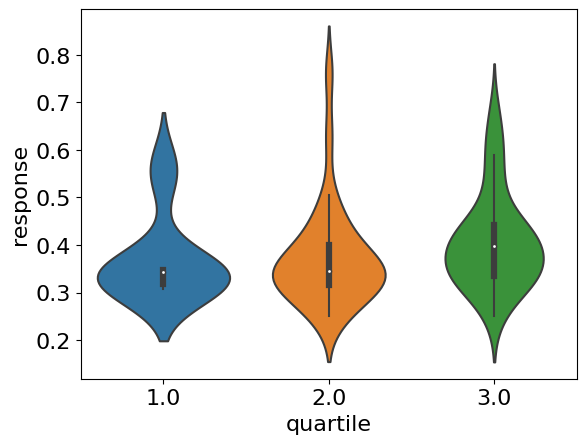

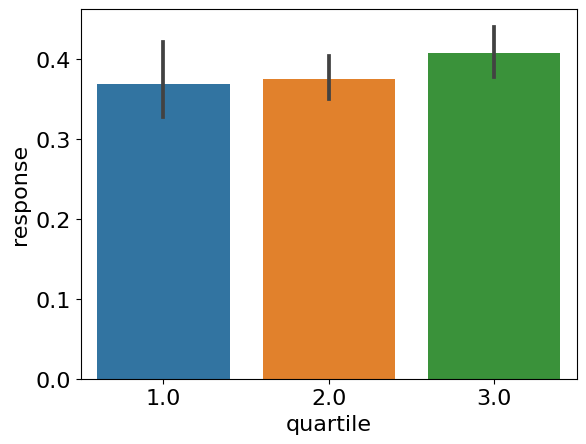

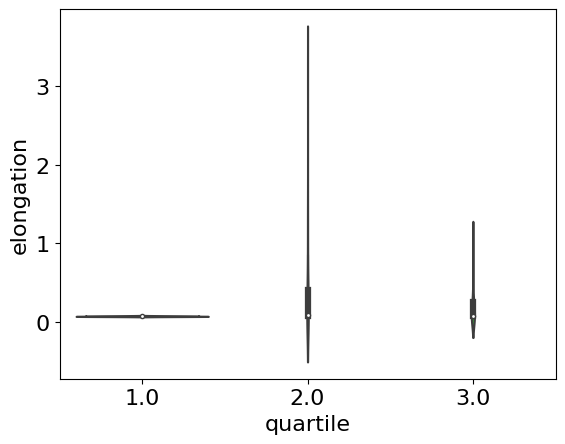

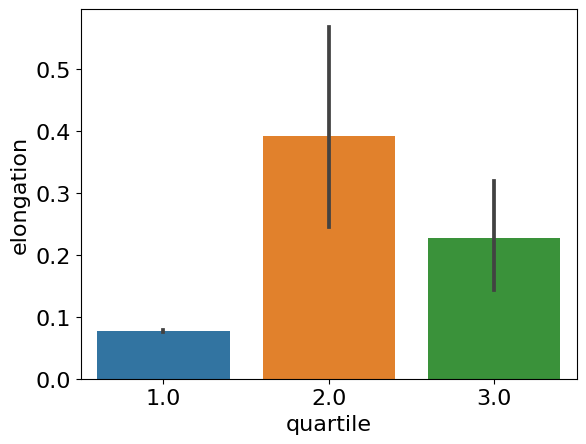

In [59]:
sns.violinplot(x='quartile', y='reaction', data=df)
plt.show()
sns.barplot(x='quartile', y='reaction', data=df)
plt.show()
sns.violinplot(x='quartile', y='response', data=df)
plt.show()
sns.barplot(x='quartile', y='response', data=df)
plt.show()
sns.violinplot(x='quartile', y='elongation', data=df)
plt.show()
sns.barplot(x='quartile', y='elongation', data=df)
plt.show()


### Plot state use per quartile

In [68]:
part_trials_df = parts_clusters.merge(trial_clusters, on=['mouse_name', 'sample', 'cluster'])

In [69]:
use_states = parts_clusters.merge(learning_times[['mouse_name',  'quartile']], on='mouse_name')
use_parts_trials = part_trials_df.merge(learning_times[['mouse_name',  'quartile']], on='mouse_name')

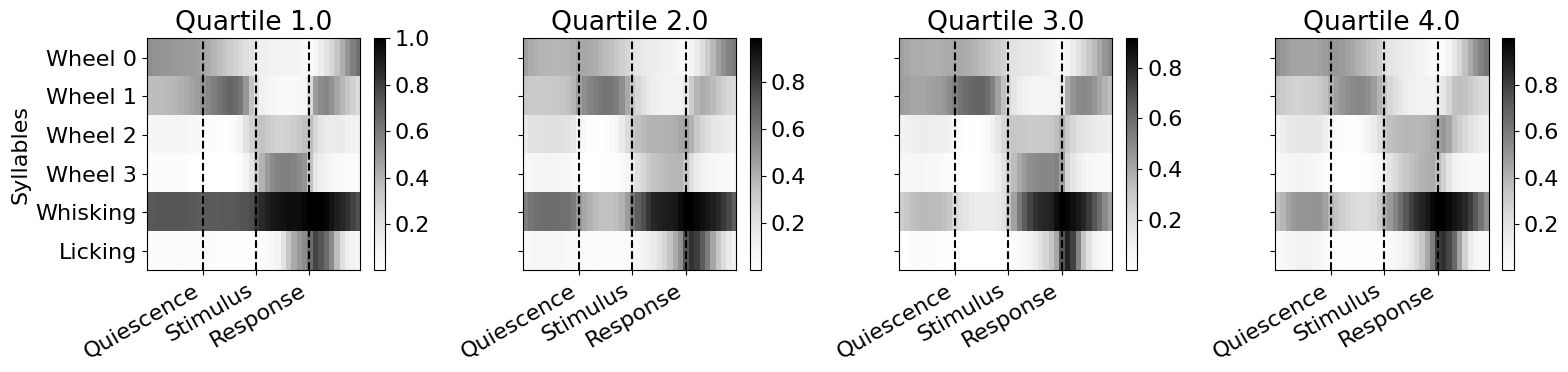

In [70]:
wheel_mapping = {0:0, 1:1, 2:2, 3:3,
                 4:0, 5:1, 6:2, 7:3,
                 8:0, 9:1, 10:2, 11:3,
                 12:0, 13:1, 14:2, 15:3}
whisker_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:1, 5:1, 6:1, 7:1,
                 8:0, 9:0, 10:0, 11:0,
                 12:1, 13:1, 14:1, 15:1}
lick_mapping = {0:0, 1:0, 2:0, 3:0,
                 4:0, 5:0, 6:0, 7:0,
                 8:1, 9:1, 10:1, 11:1,
                 12:1, 13:1, 14:1, 15:1}
replace_wheel = np.vectorize(wheel_mapping.get)
# wheel_states = replace_wheel(use_sequences)
replace_whisker = np.vectorize(whisker_mapping.get)
# whisker_states = replace_whisker(use_sequences)
replace_lick = np.vectorize(lick_mapping.get)
# lick_states = replace_lick(use_sequences)
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, len(use_states['quartile'].unique()), sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()

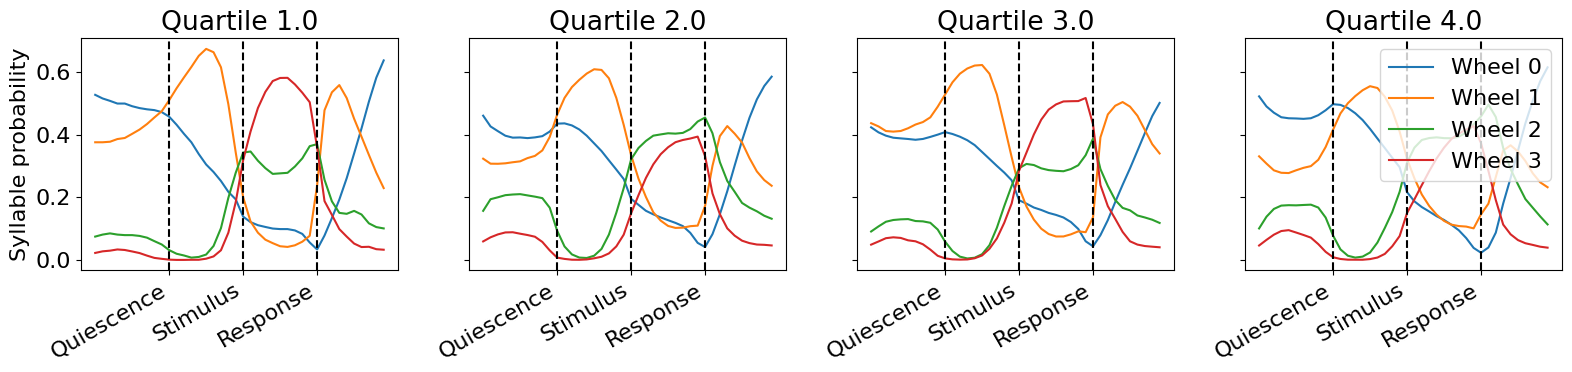

In [ ]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, len(use_states['quartile'].unique()), sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[0:4, :].T, label=['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllable probability')
plt.tight_layout()
plt.show()

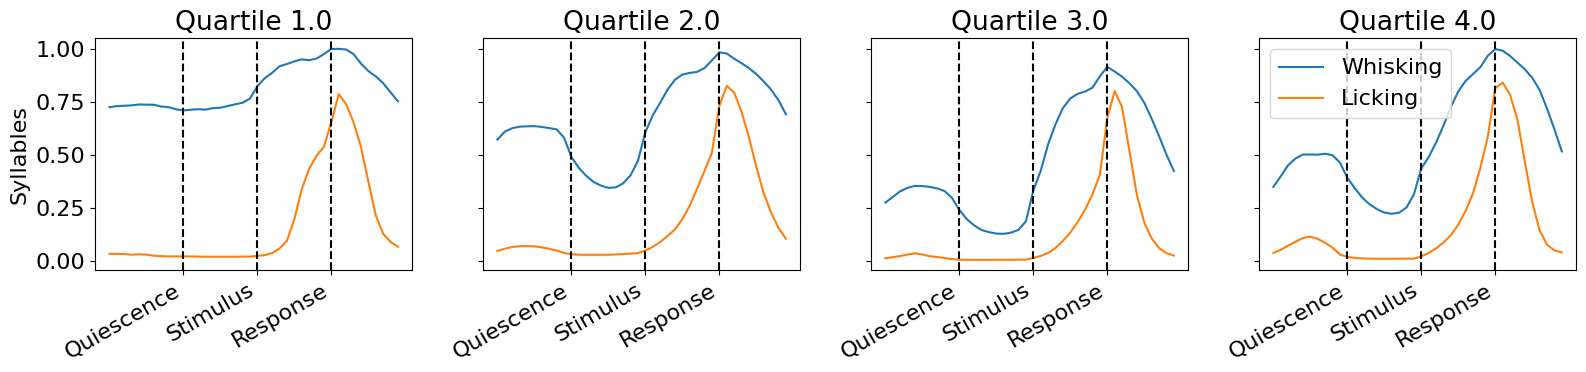

In [ ]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

color = sns.color_palette("Set2", 7)
fig, axs = plt.subplots(1, len(use_states['quartile'].unique()), sharex=True, sharey=True, figsize=(16, 4))

for q, quartile in enumerate([1., 2., 3., 4.]):
    cluster_data = use_parts_trials.loc[use_parts_trials['quartile']==quartile]
    sequences_choice = np.vstack(cluster_data[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
    use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]
    
    replace_whisker = np.vectorize(whisker_mapping.get)
    whisker_states = replace_whisker(use_sequences)
    replace_wheel = np.vectorize(wheel_mapping.get)
    wheel_states = replace_wheel(use_sequences)    
    replace_lick = np.vectorize(lick_mapping.get)
    lick_states = replace_lick(use_sequences)
    
    whisker_count = np.zeros((1, 40))
    lick_count = np.zeros((1, 40))
    wheel_count = np.zeros((4, 40))

    for b, bin in enumerate(range(40)):
        # counts, bins = np.histogram(use_sequences[:, b], range=(0,15), bins=16)
        whisker_count[0, b] = np.sum(whisker_states[:, b]==1)/len(whisker_states[:, b])
        lick_count[0, b] = np.sum(lick_states[:, b]==1)/len(lick_states[:, b])
        wheel_count[0, b] = np.sum(wheel_states[:, b]==1)/len(wheel_states[:, b])
        wheel_count[1, b] = np.sum(wheel_states[:, b]==2)/len(wheel_states[:, b])
        wheel_count[2, b] = np.sum(wheel_states[:, b]==3)/len(wheel_states[:, b])
        wheel_count[3, b] = np.sum(wheel_states[:, b]==0)/len(wheel_states[:, b])
    
    all_stacked = np.vstack([wheel_count, whisker_count, lick_count])
    # all_stacked = np.vstack([wheel_count])

    # cmap_value_1 = create_shaded_cmap(colors[q], name='cmap_value_1')
    # image = axs[c].imshow(all_stacked, cmap=cmap_value_1, aspect='auto')
    axs[q].plot(all_stacked[4:6, :].T, label=['Whisking', 'Licking'])
    # image = axs[q].imshow(all_stacked, cmap='Greys', aspect='auto')
    # fig.colorbar(image, ax=axs[q], location='right', anchor=(0, 0.3))
    # axs[q].set_yticks(np.arange(0, 6, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3', 'Whisking', 'Licking'])
    # axs[c].set_yticks(np.arange(0, 4, 1), ['Wheel 0', 'Wheel 1', 'Wheel 2', 'Wheel 3'])
    axs[q].axvline(x=10, color='k', linestyle='--')
    axs[q].axvline(x=20, color='k', linestyle='--')
    axs[q].axvline(x=30, color='k', linestyle='--')

    axs[q].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    # axs[c].set_xlabel('Time in epoch')
    axs[q].set_title('Quartile ' +str(quartile))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
axs[0].set_ylabel('Syllables')
plt.tight_layout()
plt.show()

In [ ]:
filter_mice = entropy.loc[(entropy['variable']=='True') & (entropy['session_len']>1) & (entropy['value']<.5), 'mouse_name']

                    sum_sq     df         F    PR(>F)
part_cluster    435.846631    1.0  2.366513  0.124717
Residual      77352.456687  420.0       NaN       NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   1.9872 0.4189 -1.7234  5.6978  False
     0      2  -2.7999 0.1864 -6.5534  0.9536  False
     1      2  -4.7871 0.0144 -8.7957 -0.7785   True
----------------------------------------------------


/tmp/ipykernel_13468/3581257620.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




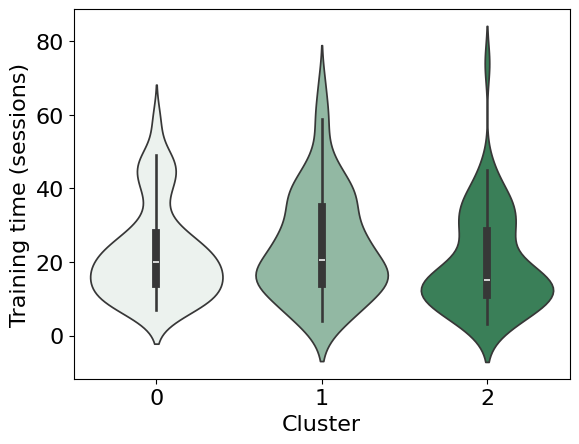

P-value for KW: 0.012
          0         1         2
0  1.000000  0.922245  0.107156
1  0.922245  1.000000  0.010799
2  0.107156  0.010799  1.000000


In [56]:

var_1 = 'training_time ~ part_cluster'
var = 'training_time'
# var = 'elongation'
# var_1 = 'elongation ~ part_cluster'
# Define the model using ordinary least squares (OLS) and fit it
data = df.dropna()
# data = df.loc[df['mouse_name'].isin(filter_mice)].dropna()
# data = pd.DataFrame(df.groupby(['mouse_name', 'part_cluster'])[var].mean()).reset_index().dropna()

model = ols(var_1, data=data).fit()

# Perform the ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA DataFrame

print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=data[var], groups=data['part_cluster'], alpha=0.05)

print(tukey)
plt.rcParams.update({'font.size': 16})
sns.violinplot(x='part_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
plt.xticks([0, 1, 2], [0, 1, 2])
# plt.ylim([0, 80])
plt.xlabel('Cluster')
plt.ylabel('Proportion correct')
plt.ylabel('Training time (sessions)')
plt.savefig(file_path+'training_time.svg', format="svg")

plt.show()

group_1 = df.loc[df['part_cluster']==0, var]
group_2 = df.loc[df['part_cluster']==1, var]
group_3 = df.loc[df['part_cluster']==2, var]


stat, p_value = stats.kruskal(group_1, group_2, group_3)
# stat, p_value = stats.kruskal(group_1, group_2)

print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(df.dropna(), val_col=var, group_col='part_cluster', p_adjust='bonferroni')
print(posthoc)
